In [79]:
# NOTE: This file contains the code for generating the train/test/validation sets
# and also contains the code for augmenting the train set in various ways,
# such as by applying oversampling or by applying random variations.
# The train/test/validation sets are generated as CSV files. They are generated from the original spectra.csv
# provided by the preprocessing file.

import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import random
from typing import List
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

################################################################################
                                  # VARIATIONS
################################################################################


def horizontal_shift(x: np.ndarray, y: np.ndarray, max_shift: int = 20) -> np.ndarray:
    """
    Shift spectrum left/right along the x-axis by interpolating the y-values.
    """
    delta = random.randint(-max_shift, max_shift)
    x_shifted = x + delta
    f = interp1d(x_shifted, y, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    return f(x)


def vertical_noise(y: np.ndarray, scale: float = 0.05) -> np.ndarray:
    """
    Add small vertical noise to the spectrum to simulate measurement fluctuations.
    """
    noise = (1 - y) * np.random.uniform(-scale, scale, size=y.shape)
    
    return np.clip(y + noise, 0, 1)


def linear_comb(y_list: List, weights: float = None) -> np.ndarray:
    """
    Combine multiple spectra from the same functional group.
    """
    y_array = np.array(y_list)
    
    if weights is None:
        weights = np.random.dirichlet(np.ones(len(y_list)), size=1)[0]
    
    return np.dot(weights, y_array)


def intensity_scaling(y: np.ndarray, gamma_range=(0.9, 1.1)) -> np.ndarray:
    """
    Randomly scale the entire spectrum's intensity.
    """
    gamma = np.random.uniform(*gamma_range)
    
    return gamma * y


def sinusoidal_drift(x: np.ndarray, y: np.ndarray, amp_range=(0.005, 0.02), freq_range=(0.5, 2)) -> np.ndarray:
    """
    Add a sinusoidal drift to the spectrum to simulate baseline distortions.
    """
    A = np.random.uniform(*amp_range)
    x_range = x[-1] - x[0]
    if x_range == 0:
        f = 0
    else:
        f = np.random.uniform(*freq_range) / x_range  # normalize over x range
    phi = np.random.uniform(0, 2 * np.pi)
    drift = A * np.sin(2 * np.pi * f * x + phi)
    
    return y + drift


def smoothing_variation(y: np.ndarray, window_choices=[5, 7, 9, 11], polyorder=2) -> np.ndarray:
    """
    Smooth the spectrum using a Savitzky-Golay filter with a random window size.
    """
    window_size = np.random.choice(window_choices)
    
    if len(y) >= window_size:
        return savgol_filter(y, window_length=window_size, polyorder=polyorder)
    
    return y

In [90]:
################################################################################
                             # AUGMENTING DATASET
################################################################################


# Apply random combinations of augmentations
def augment_randomly(df, x, n_aug=5):
    augmented_spectra = []
    augmented_labels = []
    origin_ids = [] # keep track of which original spectra we perform the augmentations on

    # Group spectra by label for linear combination
    label_to_spectra = defaultdict(list)
    for idx, row in df.iterrows():
        label_str = json.dumps(row['labels'])
        label_to_spectra[label_str].append(np.array(row['spectrum']))

    # Randomly augment each sample
    for idx, row in df.iterrows():
        original_y = np.array(row['spectrum'])
        label = row['labels']
        label_str = json.dumps(label)
        origin_id = f"sample_{idx}"

        augmented_spectra.append(original_y.tolist())
        augmented_labels.append(label)
        origin_ids.append(origin_id)

        for _ in range(n_aug):
            y_aug = original_y.copy()
            
            # Apply random augmentations
            if random.random() < 0.5:
                y_aug = horizontal_shift(x, y_aug)
            if random.random() < 0.5:
                y_aug = vertical_noise(y_aug)
            if random.random() < 0.5:
                y_aug = intensity_scaling(y_aug)
            if random.random() < 0.5:
                y_aug = sinusoidal_drift(x, y_aug)
            if random.random() < 0.5:
                y_aug = smoothing_variation(y_aug)
            
            # Disabled linear combination because SMOTE does essentially the same thing
            #if random.random() < 0.5 and len(label_to_spectra[label_str]) >= 2:
            #    y_pool = label_to_spectra[label_str]
            #    sampled = random.sample(y_pool, k=min(3, len(y_pool)))
            #    y_aug = linear_comb(sampled)

            # Normalize the data and apply baseline correction again
            y_aug = y_aug - np.min(y_aug)
            if (np.max(y_aug) != 0):
                y_aug = y_aug / np.max(y_aug)

            augmented_spectra.append(y_aug.tolist())
            augmented_labels.append(label)
            origin_ids.append(origin_id)

    return pd.DataFrame({
        'spectrum': augmented_spectra,
        'labels': augmented_labels,
        'origin_id': origin_ids
    })

# Apply individual augmentations
def augment_individually(df, x):
    # Removed linear_comb because SMOTE does essentially the same thing
    AUG_METHODS = ['horizontal_shift', 'vertical_noise', 'intensity_scaling',
                   'sinusoidal_drift', 'smoothing_variation']#, 'linear_comb']

    augmented_spectra = []
    augmented_labels = []
    origin_ids = [] # keep track of which original spectra we perform the augmentations on
    augmentation_types = []

    # Group spectra by label for linear combination
    label_to_spectra = defaultdict(list)
    for idx, row in df.iterrows():
        label_str = json.dumps(row['labels'])
        label_to_spectra[label_str].append(np.array(row['spectrum']))

    # Apply all augmentations individually to each sample
    for idx, row in df.iterrows():
        original_y = np.array(row['spectrum'])
        label = row['labels']
        label_str = json.dumps(label)
        origin_id = f"sample_{idx}"

        augmented_spectra.append(original_y.tolist())
        augmented_labels.append(label)
        origin_ids.append(origin_id)
        augmentation_types.append('none')

        for method in AUG_METHODS:
            y_aug = original_y.copy()

            if method == 'horizontal_shift':
                y_aug = horizontal_shift(x, y_aug)
            elif method == 'vertical_noise':
                y_aug = vertical_noise(y_aug)
            elif method == 'intensity_scaling':
                y_aug = intensity_scaling(y_aug)
            elif method == 'sinusoidal_drift':
                y_aug = sinusoidal_drift(x, y_aug)
            elif method == 'smoothing_variation':
                y_aug = smoothing_variation(y_aug)
            elif method == 'linear_comb':
                y_pool = label_to_spectra[label_str]
                if len(y_pool) >= 2:
                    sampled = random.sample(y_pool, k=min(3, len(y_pool)))
                    y_aug = linear_comb(sampled)
                else:
                    continue

            # Normalize the data and apply baseline correction again
            y_aug = y_aug - np.min(y_aug)
            if (np.max(y_aug) != 0):
                y_aug = y_aug / np.max(y_aug)

            augmented_spectra.append(y_aug.tolist())
            augmented_labels.append(label)
            origin_ids.append(origin_id)
            augmentation_types.append(method)

    return pd.DataFrame({
        'spectrum': augmented_spectra,
        'labels': augmented_labels,
        'origin_id': origin_ids,
        'augmentation_type': augmentation_types
    })

In [104]:
################################################################################
                         # VISUALIZING AUGMENTATIONS
################################################################################


def plot_combined_augmentations(df_aug, id_number):    
    example_id = df_aug['origin_id'].iloc[id_number]
    example_rows = df_aug[df_aug['origin_id'] == example_id].reset_index(drop=True)
    
    original_y = np.array(example_rows.iloc[0]['spectrum'])
    augmented_y_list = [np.array(row['spectrum']) for _, row in example_rows.iloc[1:].iterrows()]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, original_y, label='Original', linewidth=2)
    for i, y_aug in enumerate(augmented_y_list):
        plt.plot(x, y_aug, label=f'Augmented #{i+1}', alpha=0.7)
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')
    plt.title(f'Origin ID: {example_id} - Original vs Combined Augmentations')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_individual_augmentations(df_aug, id_number):    
    example_id = df_aug['origin_id'].iloc[id_number]
    example_rows = df_aug[df_aug['origin_id'] == example_id].reset_index(drop=True)
    
    plt.figure(figsize=(10, 6))
    for _, row in example_rows.iterrows():
        spectrum = np.array(row['spectrum'])
        method = row['augmentation_type']
        lw = 2 if method == 'none' else 1
        plt.plot(x, spectrum, label=method, linewidth=lw, alpha=0.8)
    
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')
    plt.title(f'Origin ID: {example_id} - Original vs Individual Augmentations')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [42]:
################################################################################
                             # OVERSAMPLING
################################################################################

# Code for mlsmote taken from https://github.com/theopsall/multiSmote
from multiSmote.multi_smote import MultiSmote as mlsmote

# Apply SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic samples for minority classes to combat class imbalance.
def apply_SMOTE(df):
    spectra = np.stack(df['spectrum'].to_numpy())
    labels = np.stack(df['labels'].to_numpy())
    
    smote = mlsmote()
    spectra_oversampled, labels_oversampled = smote.multi_smote(spectra, labels)

    return pd.DataFrame({
        'spectrum': [x.tolist() for x in spectra_oversampled], # pandas can't convert numpy arrays to CSVs
        'labels': [y.tolist() for y in labels_oversampled]
    })

In [12]:
################################################################################
                        # TRAIN/TEST/VALIDATION SPLIT
################################################################################

import ast
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

label_map = [
    'phenol',
    'aldehyde',
    'arene'
]


def fair_split(df, train_size, validation_size):
    # Counting how many spectra contain each group (just for logging)
    counts = {}
    for i in range(len(label_map)):
        counts[label_map[i]] = df['labels'].apply(lambda L: L[i] == 1).sum()
    print('Spectra counts per group:')
    for name, cnt in counts.items():
        print(f'{name}: {cnt}')

    try:
        # Stage 1 (stratifier): (1 - TRAIN_SIZE)% for “remainder”, TRAIN_SIZE% for training
        strat1 = MultilabelStratifiedShuffleSplit(
            n_splits=1, 
            test_size=1 - train_size,    # (1 - TRAIN_SIZE)% goes to df_remain
            random_state=42
        )
        
        Y = np.stack(df['labels'].values)
        
        # Split the dataset into a train set and a remainder
        train_idx, remain_idx = next(strat1.split(df, Y))
        df_train = df.iloc[train_idx].reset_index(drop=True)
        Y_train  = Y[train_idx]
        df_remain = df.iloc[remain_idx].reset_index(drop=True)
        Y_remain  = Y[remain_idx]

        print(f"\nAfter Stage 1 → Train: {len(df_train)} (≈{train_size * 100.0}%), Remainder: {len(df_remain)} (≈{(1 - train_size) * 100.0}%)")

        strat2 = MultilabelStratifiedShuffleSplit(
            n_splits=1,
            test_size=validation_size,   # VALIDATION_SIZE% of df_remain → validation
            random_state=42
        )
    
        # Split the remainder into a validation and test set
        remain_train_idx, remain_test_idx = next(strat2.split(df_remain, Y_remain))

        df_test  = df_remain.iloc[remain_train_idx].reset_index(drop=True)
        df_val   = df_remain.iloc[remain_test_idx].reset_index(drop=True)

        print(f"After Stage 2 → Test: {len(df_test)} (≈{(1 - train_size) * (1 - validation_size) * 100.0}%), Validation: {len(df_val)} (≈{(1 - train_size) * validation_size * 100.0}%)")

    except ImportError:
        # Fallback (non‐stratified) splitting if iterstrat is missing
        # Stage 1: TRAIN_SIZE% train, (1 - TRAIN_SIZE)% remainder
        df_train, df_remain = train_test_split(
            dataset.df, 
            test_size=1 - train_size,
            random_state=42,
            shuffle=True
        )
        print(f"\nAfter Stage 1 (fallback) → Train: {len(df_train)}, Remainder: {len(df_remain)}")

        # Stage 2: within remainder, do (1 - VALIDATION_SIZE)% for test and VALIDATION_SIZE% for val
        df_test, df_val = train_test_split(
            df_remain,
            test_size=VALIDATION_SIZE,   # VALIDATION_SIZE of “remainder” is the validation set 
            random_state=42,
            shuffle=True
        )
        print(f"After Stage 2 (fallback) → Test: {len(df_test)}, Validation: {len(df_val)}")

    print()
    for i in range(len(label_map)):
        name = label_map[i]
        orig_tot = df['labels'].apply(lambda L: L[i] == 1).sum()
        train_tot = df_train['labels'].apply(lambda L: L[i] == 1).sum()
        test_tot  = df_test['labels'].apply(lambda L: L[i] == 1).sum()
        val_tot   = df_val['labels'].apply(lambda L: L[i] == 1).sum()
        print(f"Label = {label_map[i]}")
        print(f" Overall prevalence: {orig_tot / len(df):.2%}, total: {orig_tot}")
        print(f"→ Train prevalence: {train_tot / len(df_train):.2%}, total: {train_tot}")
        print(f"→ Test prevalence: {test_tot / len(df_test):.2%}, total: {test_tot}")
        print(f"→ Val prevalence: {val_tot / len(df_val):.2%}, total: {val_tot}\n")

    return df_train, df_test, df_val

In [28]:
################################################################################
                          # DATA CONVERSION
################################################################################

import json

def csv_to_df(csv_path):
    df = pd.read_csv(ORIGINAL_CSV)
    df['spectrum'] = df['spectrum'].apply(json.loads)
    df['labels'] = df['labels'].apply(json.loads)
    return df

def df_to_csv(df, csv_path):
    # Don't modify the original dataframe and only consider the spectrum and labels columns
    df_clone = df.copy()[['spectrum', 'labels']]
    df_clone['spectrum'] = df_clone['spectrum'].apply(lambda L: json.dumps(L))
    df_clone['labels'] = df_clone['labels'].apply(lambda L: json.dumps(L))
    df_clone.to_csv(csv_path, index=False)

def labels_to_multi_hot_vector(labels):
    multi_hot_vector = []
    for i in range(len(label_map)):
        if label_map[i] in labels:
            multi_hot_vector.append(1)
        else:
            multi_hot_vector.append(0)
    return multi_hot_vector

In [7]:
ORIGINAL_CSV = 'spectra.csv'
AUGMENTED_CSV = 'augmented_spectra.csv'
IND_AUGMENTED_CSV = 'individual_augmented_spectra.csv'

# All of the csv reads/writes are in different cells. This is to make it possible to only read/write one csv without redoing
# a lot of work for all the other CSVs.

df = csv_to_df(ORIGINAL_CSV)
# To start, convert labels from string representations to multi-hot vectors
df['labels'] = df['labels'].apply(labels_to_multi_hot_vector)

In [13]:
# Split data into 75% training set, 15% test set, 10% validation set
df_train, df_test, df_val = fair_split(df, 0.75, 0.4)

# Save test and validation sets since we don't want to apply augmentations to them
df_to_csv(df_test, 'spectra_test.csv')
df_to_csv(df_val, 'spectra_validation.csv')

# Save a 'clean' training set as a base measure
df_to_csv(df_train, 'spectra_train_clean.csv')

Spectra counts per group:
phenol: 711
aldehyde: 443
arene: 9053

After Stage 1 → Train: 11711 (≈75.0%), Remainder: 3904 (≈25.0%)
After Stage 2 → Test: 2342 (≈15.0%), Validation: 1562 (≈10.0%)

Label = phenol
 Overall prevalence: 4.55%, total: 711
→ Train prevalence: 4.55%, total: 533
→ Test prevalence: 4.57%, total: 107
→ Val prevalence: 4.55%, total: 71

Label = aldehyde
 Overall prevalence: 2.84%, total: 443
→ Train prevalence: 2.83%, total: 332
→ Test prevalence: 2.86%, total: 67
→ Val prevalence: 2.82%, total: 44

Label = arene
 Overall prevalence: 57.98%, total: 9053
→ Train prevalence: 57.98%, total: 6790
→ Test prevalence: 57.98%, total: 1358
→ Val prevalence: 57.94%, total: 905



In [26]:
# Apply SMOTE to the training set to counteract class imbalance and save the result
print('Labels in the training set before SMOTE:')
for i in range(len(label_map)):
    label_count_before = df_train['labels'].apply(lambda L: L[i] == 1).sum()
    print('%s: %i' % (label_map[i], label_count_before))
print('Without SMOTE the training set contains %i datapoints\n\n' % (len(df_train)))

df_train_smote = apply_SMOTE(df_train)
df_to_csv(df_train_smote, 'spectra_train_SMOTE.csv')

print('Labels in the training set after SMOTE:')
for i in range(len(label_map)):
    label_count_after = df_train_smote['labels'].apply(lambda L: L[i] == 1).sum()
    print('%s: %i' % (label_map[i], label_count_after))
print('With SMOTE the training set contains %i datapoints (%f%% of training set)' % (len(df_train_smote), (len(df_train_smote) / len(df_train) * 100.0)))

Labels in the training set before SMOTE:
phenol: 533
aldehyde: 332
arene: 6790
Without SMOTE the training set contains 11711 datapoints


Labels in the training set after SMOTE:
phenol: 6790
aldehyde: 6790
arene: 6790
With SMOTE the training set contains 24426 datapoints (208.573136% of training set)


In [92]:
# Apply augmentations to the training set without SMOTE and save the result
MIN_WAVENUMBER = 400
MAX_WAVENUMBER = 4000
NUM_POINTS = MAX_WAVENUMBER - MIN_WAVENUMBER # every spectrum should have a y value for every wave number
x = np.linspace(MIN_WAVENUMBER, MAX_WAVENUMBER, NUM_POINTS)

# When augmentations are applied one at a time, performance generally doesn't improve
# Besides, augment_individually tends to generate ridiculously dataframes which take forever to convert to CSVs
# and train with
#df_train_ind_aug = augment_individually(df_train, x)
#df_to_csv(df_train_ind_aug, 'spectra_train_ind_aug.csv')

df_train_rand_aug = augment_randomly(df_train, x, n_aug=5)
df_to_csv(df_train_rand_aug, 'spectra_train_rand_aug.csv')

In [96]:
# Apply augmentations to the training set with SMOTE and save the result

# Removed for the same reason stated above
#df_train_ind_aug_smote = augment_individually(df_train_smote, x)
#df_to_csv(df_train_ind_aug_smote, 'spectra_train_ind_aug_smote.csv')

# Since the dataset with SMOTE contains more samples the number of augmentations per sample can be brought down a bit
# keeping it at 5 generates a ridiculously large 16GB CSV which will take too long to train with.
df_train_rand_aug_smote = augment_randomly(df_train_smote, x, n_aug=2)
df_to_csv(df_train_rand_aug_smote, 'spectra_train_rand_aug_smote.csv')

Number of datapoints in each training set:
Unaltered training set: 11711 (0.000000% bigger))
Training set with SMOTE applied: 24426 (108.573136% bigger))
Training set with augmentations applied: 70266 (500.000000% bigger))
Training set with SMOTE + augmentations applied: 73278 (525.719409% bigger))


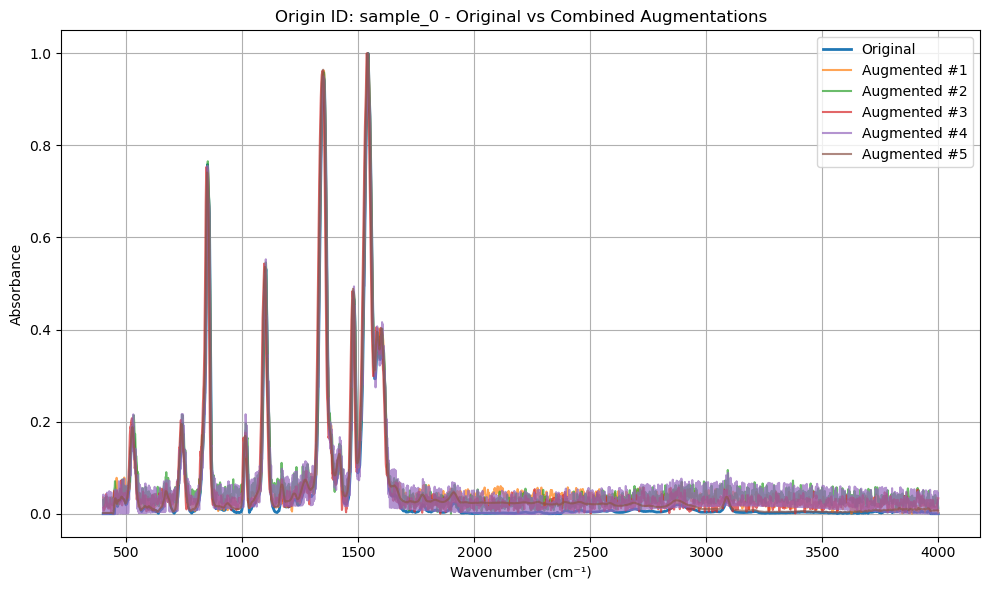

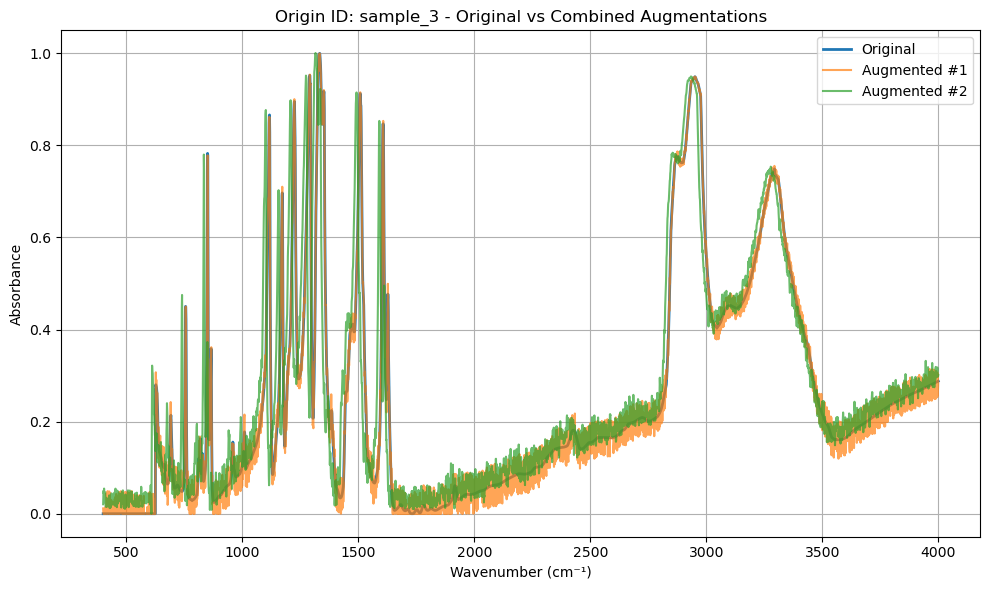

In [107]:
print('Number of datapoints in each training set:')
print('Unaltered training set: %i (%f%% bigger))' % (len(df_train), 0.0))
print('Training set with SMOTE applied: %i (%f%% bigger))' % (len(df_train_smote), (len(df_train_smote) / len(df_train)) * 100.0 - 100.0))
print('Training set with augmentations applied: %i (%f%% bigger))' % (len(df_train_rand_aug), (len(df_train_rand_aug) / len(df_train)) * 100.0 - 100.0))
print('Training set with SMOTE + augmentations applied: %i (%f%% bigger))' % (len(df_train_rand_aug_smote), (len(df_train_rand_aug_smote) / len(df_train)) * 100.0 - 100.0))

plot_combined_augmentations(df_train_rand_aug, id_number=1)
plot_combined_augmentations(df_train_rand_aug_smote, id_number=10)